In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset
%matplotlib inline

In [3]:
df=pd.read_csv('Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv')
df.head()

,Date,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
0,30/08/2024,16436,10705,225,19026,3925,59.0
1,15/09/2023,15499,10671,267,18421,4519,61.0
2,28/12/2021,1756,2352,0,3775,0,13.0
3,11/01/2023,10536,8347,223,14072,0,48.0
4,11/09/2021,820,612,0,1283,0,11.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1918 non-null   object 
 1   Local Route   1918 non-null   int64  
 2   Light Rail    1918 non-null   int64  
 3   Peak Service  1918 non-null   int64  
 4   Rapid Route   1918 non-null   int64  
 5   School        1918 non-null   int64  
 6   Other         1898 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 105.0+ KB


COVERT THE DATE COLUMN FROM CATEGORICAL TO ACTUAL DATE TIME TYPE AND SET IT AS THE INDEX

In [11]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

/var/folders/hq/tl0wx9k16494y339m2zdy1kh0000gn/T/ipykernel_5952/1318682558.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date']=pd.to_datetime(df['Date'])


In [12]:
print(df.isnull().sum())

Local Route      0
Light Rail       0
Peak Service     0
Rapid Route      0
School           0
Other           20
dtype: int64


CHECK FOR THE NULL VALUES/MISSING VALUES AND FILL THEM WITH FORWARD FILL

REMOVING THE NULL VALUES WILL AFFECT THE DATASET BY 1% BUT WE CAN USE FORWARD FILL FOR THE TIME SERIES WHICH WILL BE BETTER

In [13]:
df.fillna(method='ffill',inplace=True)

/var/folders/hq/tl0wx9k16494y339m2zdy1kh0000gn/T/ipykernel_5952/4116506308.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill',inplace=True)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1918 entries, 2024-08-30 to 2023-07-26
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Local Route   1918 non-null   int64  
 1   Light Rail    1918 non-null   int64  
 2   Peak Service  1918 non-null   int64  
 3   Rapid Route   1918 non-null   int64  
 4   School        1918 non-null   int64  
 5   Other         1918 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 104.9 KB


EXTRACT THEE DAY NAME FROM THE INDEX AND CREATE A NEW COLUMN DAY TYPE AND DETERMINE IT IS WEEKEND OR WEEKDAY

ALSO EXTRACT THE MONTH FROM THE DATE AND STORE IT IN A NEW COLUMN AS MONTHLY PERIOD

In [41]:
df['Day'] = df.index.day_name()
df['Day Type'] = df['Day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df['Month'] = df.index.to_period('M')

In [39]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1918 entries, 2024-08-30 to 2023-07-26
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   Local Route   1918 non-null   int64    
 1   Light Rail    1918 non-null   int64    
 2   Peak Service  1918 non-null   int64    
 3   Rapid Route   1918 non-null   int64    
 4   School        1918 non-null   int64    
 5   Other         1918 non-null   float64  
 6   Day           1918 non-null   object   
 7   Day Type      1918 non-null   object   
 8   Month         1918 non-null   period[M]
dtypes: float64(1), int64(5), object(2), period[M](1)
memory usage: 149.8+ KB


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other,Day,Day Type,Month
Date,,,,,,,,,
2024-08-30,16436,10705,225,19026,3925,59.0,Friday,Weekday,2024-08
2023-09-15,15499,10671,267,18421,4519,61.0,Friday,Weekday,2023-09
2021-12-28,1756,2352,0,3775,0,13.0,Tuesday,Weekday,2021-12
2023-01-11,10536,8347,223,14072,0,48.0,Wednesday,Weekday,2023-01
2021-09-11,820,612,0,1283,0,11.0,Saturday,Weekend,2021-09


VISUALIZATION 1:
USED BARPLOT TO VISUALIZE THE AVERAGE DAILY RIDERSHIP BY EACH SERVICE TYPE

IT CALCULATES AVERAGE DAILY RIDERSHIP FOR ALL THE NUMERIC COLUMNS AND WE ARE CONSIDERING ONLY THE NUMERIC TYPE HERE

/var/folders/hq/tl0wx9k16494y339m2zdy1kh0000gn/T/ipykernel_5952/90876211.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ridership.values, y=avg_ridership.index, palette='Blues_r')


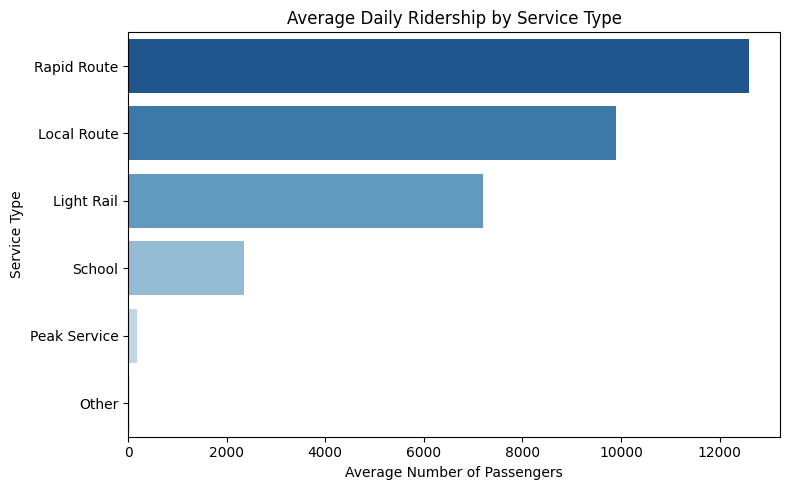

In [19]:
plt.figure(figsize=(8,5))
avg_ridership = df.mean(numeric_only=True).sort_values(ascending=False)
sns.barplot(x=avg_ridership.values, y=avg_ridership.index, palette='Blues_r')
plt.title("Average Daily Ridership by Service Type")
plt.xlabel("Average Number of Passengers")
plt.ylabel("Service Type")
plt.tight_layout()
plt.show()

INSIGHT 1:
THE RAPID ROUTE HAS THE HIGHEST NUMBER OF PASSENGERS ON AVERAGE EACH DAY. THIS MEANS MOST PEOPLE PREFER USING RAPID ROUTES FOR THEIR DAILY TRAVEL, SO IT’S IMPORTANT TO KEEP THESE ROUTES WELL MANAGED AND RELIABLE TO MEET PEOPLE’S NEEDS.



VISUALIZATION 2:
USING THE BOX PLOT TO CHECK FOR THE DISTRIBUTION OF PASSENGERS ACROSS THE SERVICE TYPES AND ALSO CHECK FOR THE OUTLIERS


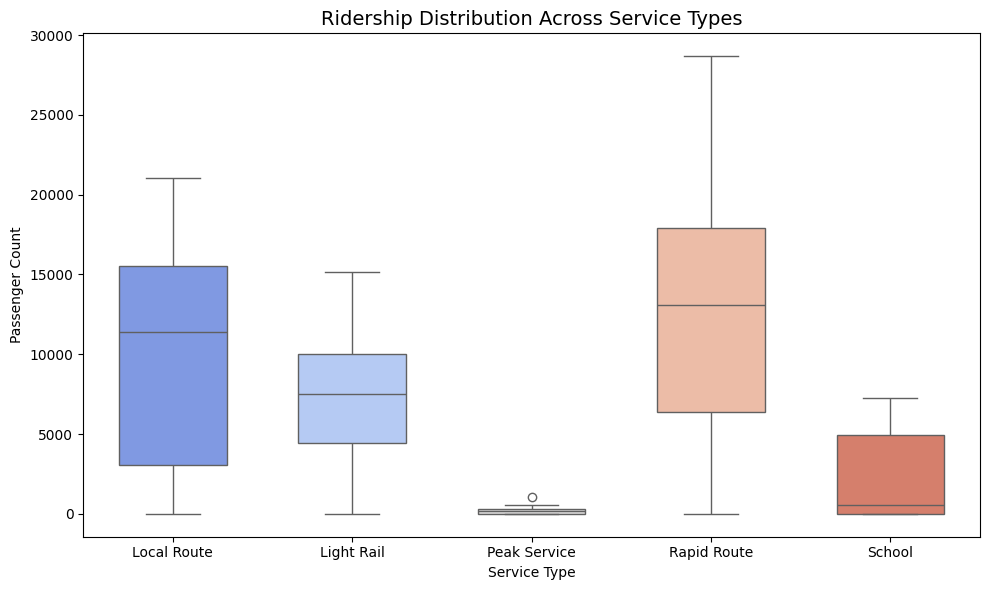

In [22]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']], 
            palette='coolwarm', width=0.6)
plt.title("Ridership Distribution Across Service Types", fontsize=14)
plt.ylabel("Passenger Count")
plt.xlabel("Service Type")
plt.tight_layout()
plt.show()

INSIGHT 2:
THE RAPID ROUTE AND LOCAL ROUTE HAVE THE HIGHEST PASSENGER COUNTS, SHOWING THAT THESE SERVICES ARE THE MOST WIDELY USED BY THE PUBLIC. IN CONTRAST, PEAK SERVICE AND SCHOOL ROUTES HAVE MUCH LOWER RIDERSHIP, MEANING THEY ARE USED ONLY BY A SMALLER GROUP OR DURING SPECIFIC TIMES. THIS SUGGESTS THAT MOST DAILY TRAVEL DEPENDS ON RAPID AND LOCAL ROUTES, SO KEEPING THESE ROUTES FREQUENT AND RELIABLE SHOULD BE THE MAIN FOCUS.

VISUALIZATION 3:
THE DATA IS GROPUED BY DAY TYPE TO CALCULATE THE AVERAGE RIDERSHIP FOR EACH TYPE AND THEN WE HAVE MELTED THE DATA TO RESHAPE THE DATA FOR BETTER BAR CHART

In [30]:
weekday_avg = df.groupby('Day Type')[['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']].mean().reset_index()
weekday_avg


,Day Type,Local Route,Light Rail,Peak Service,Rapid Route,School
0,Weekday,12755.348175,8355.815328,251.413869,15297.278102,3293.729197
1,Weekend,2731.512774,4294.523723,0.000000,5847.051095,0.109489


In [31]:
melted = weekday_avg.melt(id_vars='Day Type', 
                          var_name='Service Type', 
                          value_name='Average Journeys')


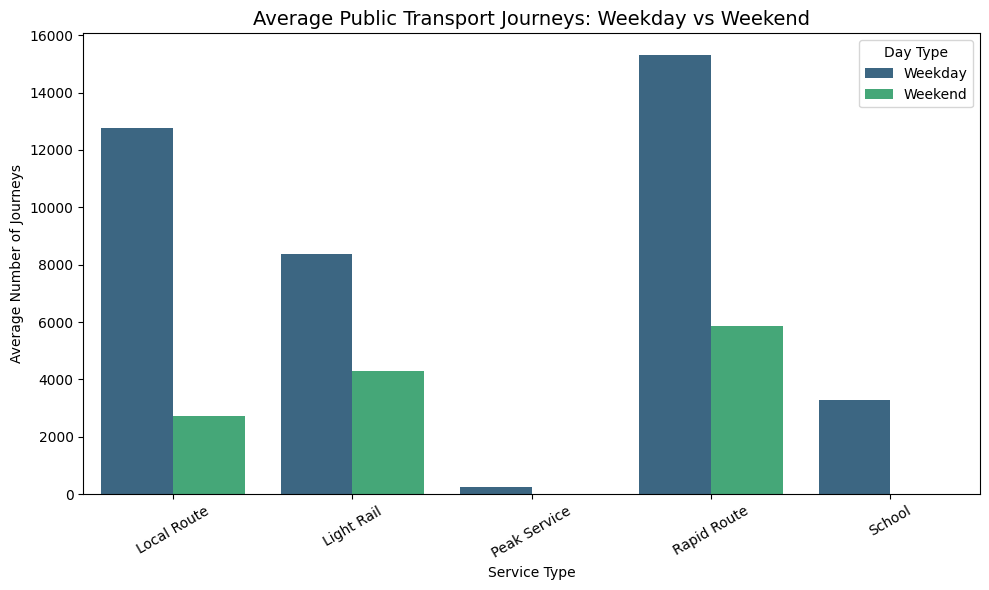

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(data=melted, x='Service Type', y='Average Journeys', hue='Day Type', palette='viridis')
plt.title('Average Public Transport Journeys: Weekday vs Weekend', fontsize=14)
plt.xlabel('Service Type')
plt.ylabel('Average Number of Journeys')
plt.legend(title='Day Type')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

INSIGHT 3:
WEEKDAY RIDERSHIP IS MUCH HIGHER THAN WEEKEND RIDERSHIP ACROSS ALL SERVICES, ESPECIALLY FOR RAPID ROUTE AND LOCAL ROUTE. THIS MEANS MOST PEOPLE USE PUBLIC TRANSPORT MAINLY FOR WORK, SCHOOL, AND DAILY COMMUTING, WHILE TRAVEL DEMAND DROPS NOTICEABLY ON WEEKENDS.

VISUALIZATION 4:
USING HEATMAP TO CHECK HOW THE DIFFERENT SERVICE TYPES ARE RELATED TO EACH OTHER. IT SHOWS HOW THE RISE OR FALL IN ONE SERVICE USAGE CHANGES THE OTHERS

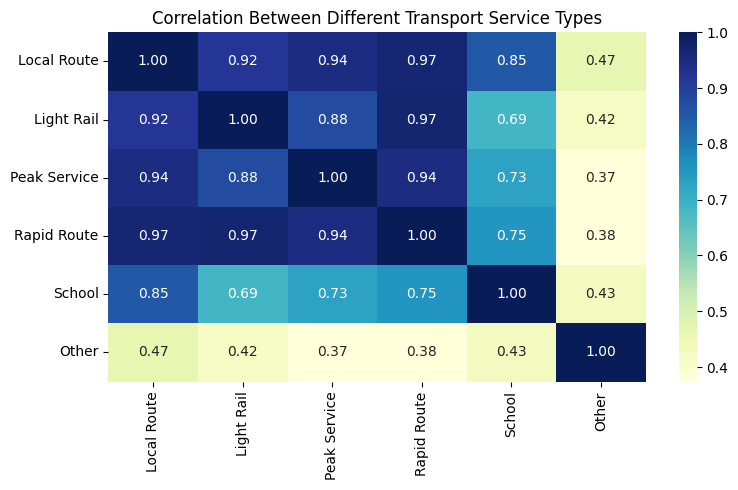

In [36]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(8,5))
sns.heatmap(numeric_df.corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Between Different Transport Service Types")
plt.tight_layout()
plt.show()

INSIGHT 4:
THERE IS A STRONG POSITIVE RELATIONSHIP BETWEEN LOCAL ROUTE, LIGHT RAIL, AND RAPID ROUTE, MEANING WHEN ONE OF THESE SERVICES GETS MORE PASSENGERS, THE OTHERS USUALLY DO TOO.
THIS SUGGESTS THAT PEOPLE OFTEN USE THESE SERVICES TOGETHER OR THAT THEY SERVE SIMILAR TRAVEL NEEDS, SHOWING A CONNECTED TRAVEL PATTERN ACROSS THE MAIN ROUTES.


VISUALIZATION 5:
USED LINE GRAPH TO SHOW HOW THE PASSENGERS CHANGES FOR EVERY MONTH FOR EACH SERVICE TYPE.

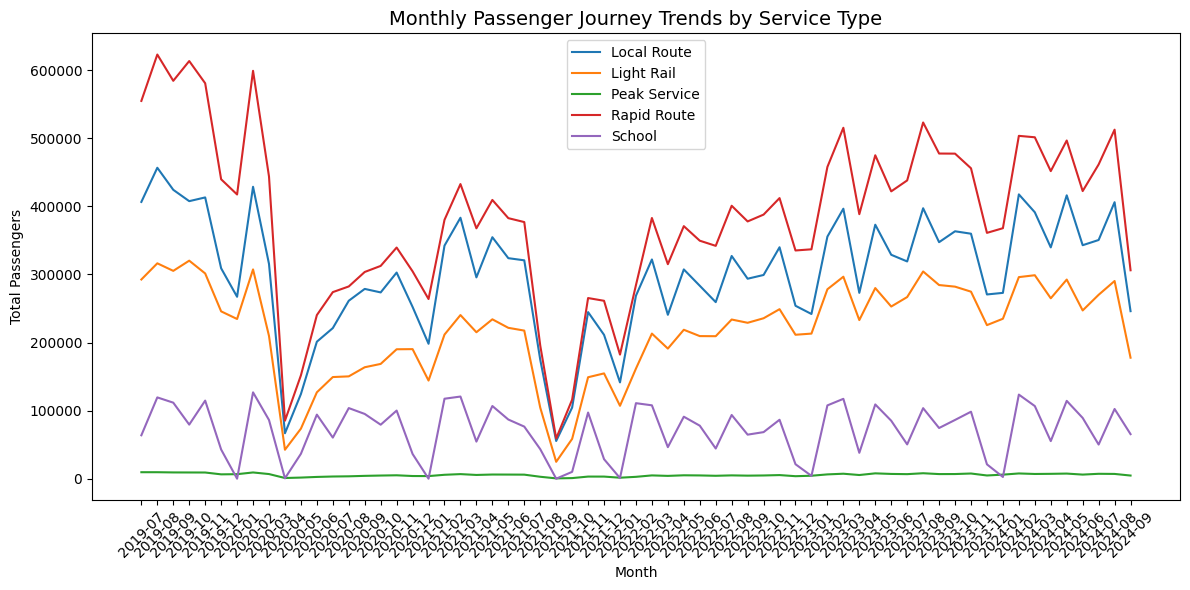

In [43]:

monthly_sum = df.groupby('Month')[cols].sum().reset_index()
monthly_sum['Month'] = monthly_sum['Month'].astype(str)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sum, x='Month', y='Local Route', label='Local Route')
sns.lineplot(data=monthly_sum, x='Month', y='Light Rail', label='Light Rail')
sns.lineplot(data=monthly_sum, x='Month', y='Peak Service', label='Peak Service')
sns.lineplot(data=monthly_sum, x='Month', y='Rapid Route', label='Rapid Route')
sns.lineplot(data=monthly_sum, x='Month', y='School', label='School')
plt.title("Monthly Passenger Journey Trends by Service Type", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Total Passengers")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


INSIGHT 5:
THE RAPID ROUTE AND LOCAL ROUTE CONSISTENTLY HAVE THE HIGHEST NUMBER OF PASSENGERS, WHILE PEAK SERVICE STAYS VERY LOW THROUGHOUT.
THERE ARE NOTICEABLE DROPS IN RIDERSHIP AT CERTAIN MONTHS, LIKELY DUE TO HOLIDAYS OR EXTERNAL FACTORS, FOLLOWED BY STEADY RECOVERIES.
THIS MEANS MOST PEOPLE RELY ON RAPID AND LOCAL ROUTES FOR REGULAR TRAVEL, AND THESE SERVICES PLAY THE MAIN ROLE IN OVERALL TRANSPORT DEMAND.


HEREWITH EDA IS COMPLETED

NOW FOR THE PREDICTION PART WE CAN USE ARIMA MODEL
FOR USING ARIMA WE NEED TO CHECK FOR STATIONARY. MEANS THE MEAN AND STD.DEVIATION OF TREND AND SEASONALITY MUST BE CONSTANT FOR TIME SERIES ANALYSIS OR FORECAST. 

WE CAN CHECK FOR STATIONARY USING THE DICKKY FULLER TEST FOR ALL THE COLUMNS AS WE NEED TO PREDICT OR FORECAST FOR ALL THE COLUMNS EXCEPT OTHERS AND USE DIFFERENCING FOR MAKING THE DATA STATIONARY IF NEEDED.

P-VALUE DETERMINES THE STATIONARY 
IF P > 0.05 THEN NOT STATIONARY
IF P < 0.05 THEN IT IS STATIONARY

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Local Route Stationarity Check
result_local = adfuller(df['Local Route'].dropna())
print("ADF Test for Local Route")
print(f"ADF Statistic: {result_local[0]}")
print(f"p-value: {result_local[1]}")
print(f"Lags used: {result_local[2]}")
print(f"Number of Observations: {result_local[3]}")
if result_local[1] <= 0.05:
    print("Local Route is Stationary\n")
else:
    print("Local Route is NOT Stationary\n")


ADF Test for Local Route
ADF Statistic: -44.415952606112306
p-value: 0.0
Lags used: 0
Number of Observations: 1917
✅ Local Route is Stationary



In [ ]:
# Light Rail Stationarity Check
result_light = adfuller(df['Light Rail'].dropna())
print("ADF Test for Light Rail")
print(f"ADF Statistic: {result_light[0]}")
print(f"p-value: {result_light[1]}")
print(f"Lags used: {result_light[2]}")
print(f"Number of Observations: {result_light[3]}")
if result_light[1] <= 0.05:
    print("Light Rail is Stationary\n")
else:
    print("Light Rail is NOT Stationary\n")


ADF Test for Light Rail
ADF Statistic: -11.372676807533038
p-value: 8.899766119330144e-21
Lags used: 17
Number of Observations: 1900
✅ Light Rail is Stationary



In [ ]:
# Peak Service Stationarity Check
result_peak = adfuller(df['Peak Service'].dropna())
print("ADF Test for Peak Service")
print(f"ADF Statistic: {result_peak[0]}")
print(f"p-value: {result_peak[1]}")
print(f"Lags used: {result_peak[2]}")
print(f"Number of Observations: {result_peak[3]}")
if result_peak[1] <= 0.05:
    print("Peak Service is Stationary\n")
else:
    print("Peak Service is NOT Stationary\n")


ADF Test for Peak Service
ADF Statistic: -43.72380096176087
p-value: 0.0
Lags used: 0
Number of Observations: 1917
✅ Peak Service is Stationary



In [ ]:
# Rapid Route Stationarity Check
result_rapid = adfuller(df['Rapid Route'].dropna())
print("ADF Test for Rapid Route")
print(f"ADF Statistic: {result_rapid[0]}")
print(f"p-value: {result_rapid[1]}")
print(f"Lags used: {result_rapid[2]}")
print(f"Number of Observations: {result_rapid[3]}")
if result_rapid[1] <= 0.05:
    print("Rapid Route is Stationary\n")
else:
    print("Rapid Route is NOT Stationary\n")


ADF Test for Rapid Route
ADF Statistic: -44.251737192101636
p-value: 0.0
Lags used: 0
Number of Observations: 1917
✅ Rapid Route is Stationary



In [ ]:
# School Service Stationarity Check
result_school = adfuller(df['School'].dropna())
print("ADF Test for School Service")
print(f"ADF Statistic: {result_school[0]}")
print(f"p-value: {result_school[1]}")
print(f"Lags used: {result_school[2]}")
print(f"Number of Observations: {result_school[3]}")
if result_school[1] <= 0.05:
    print("School Service is Stationary\n")
else:
    print("School Service is NOT Stationary\n")


ADF Test for School Service
ADF Statistic: -44.79833798863761
p-value: 0.0
Lags used: 0
Number of Observations: 1917
✅ School Service is Stationary



/var/folders/hq/tl0wx9k16494y339m2zdy1kh0000gn/T/ipykernel_5952/487344184.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = numeric_df.resample('M').mean()


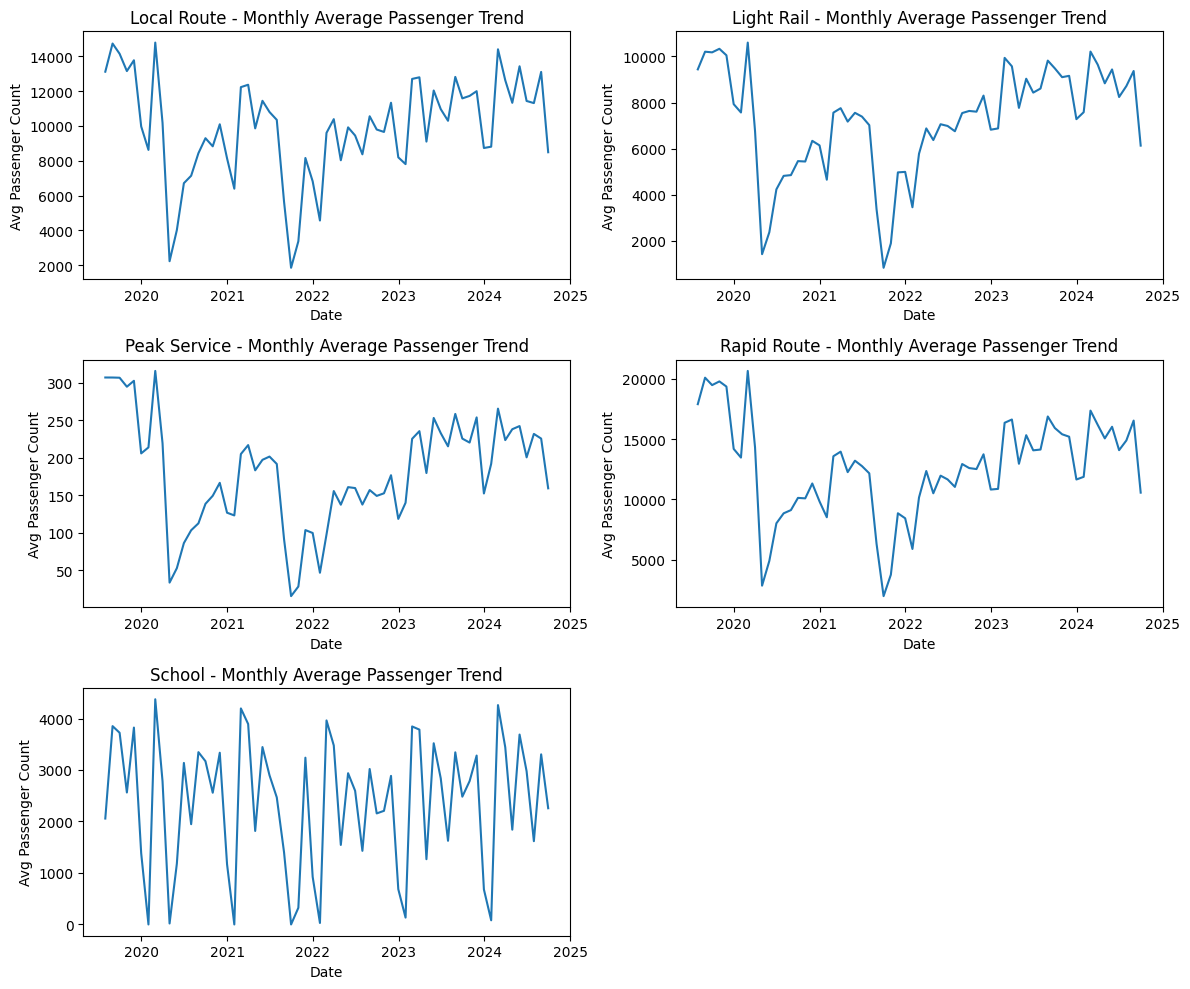

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df.index = pd.to_datetime(df.index)


numeric_df = df.select_dtypes(include='number')


monthly_df = numeric_df.resample('M').mean()

services = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

plt.figure(figsize=(12, 10))
for i, service in enumerate(services, 1):
    plt.subplot(3, 2, i)
    if service in monthly_df.columns:
        plt.plot(monthly_df.index, monthly_df[service], color='tab:blue')
        plt.title(f"{service} - Monthly Average Passenger Trend")
        plt.xlabel("Date")
        plt.ylabel("Avg Passenger Count")
    else:
        plt.text(0.5, 0.5, f"{service} not found", ha='center', va='center')
    plt.tight_layout()

plt.show()


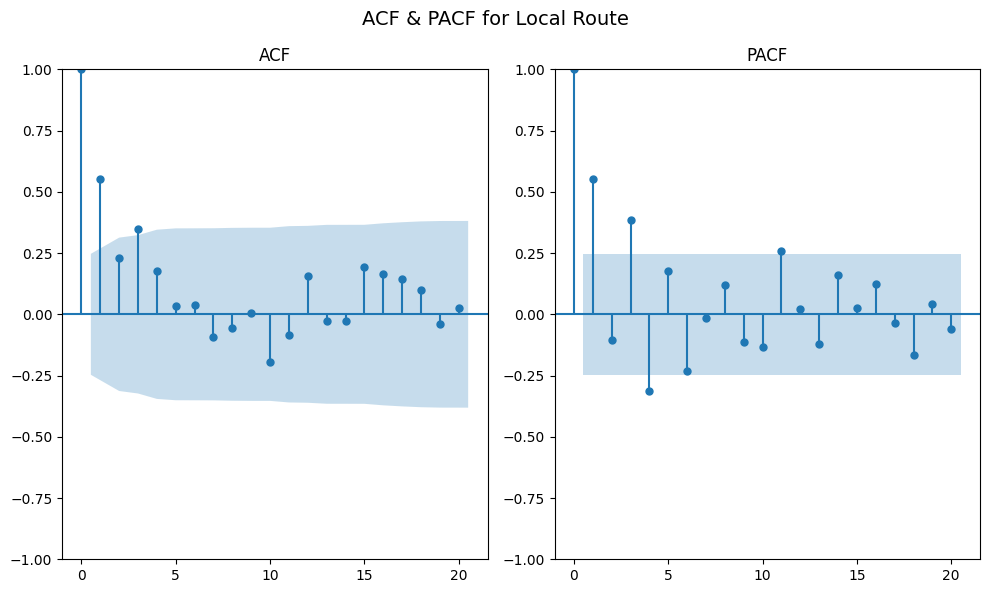

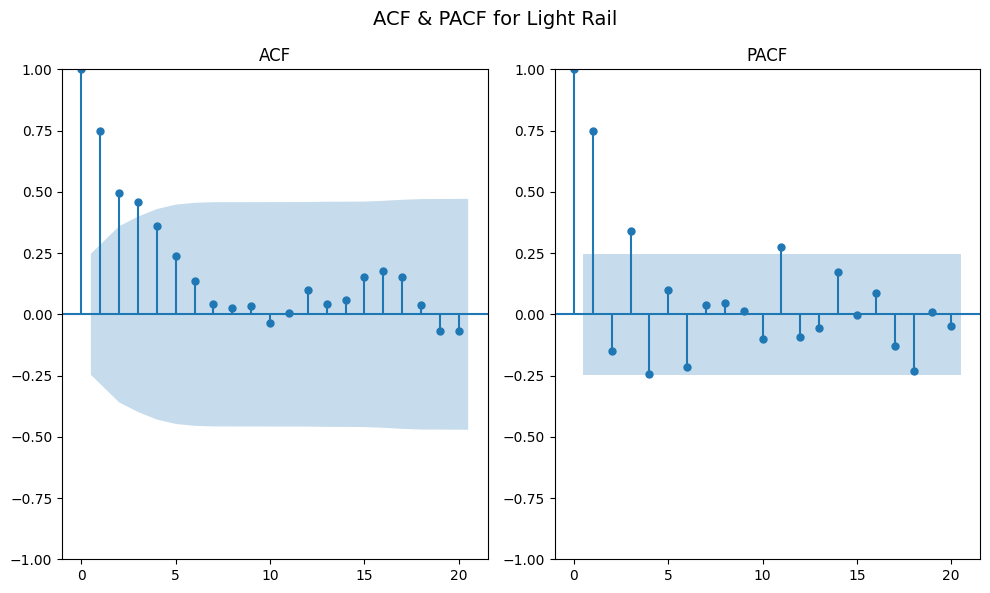

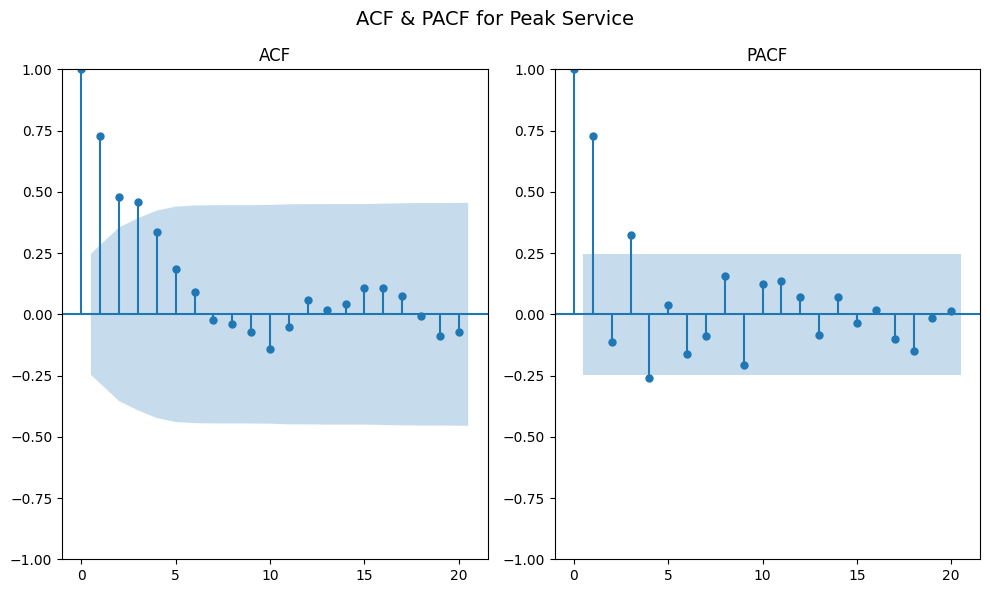

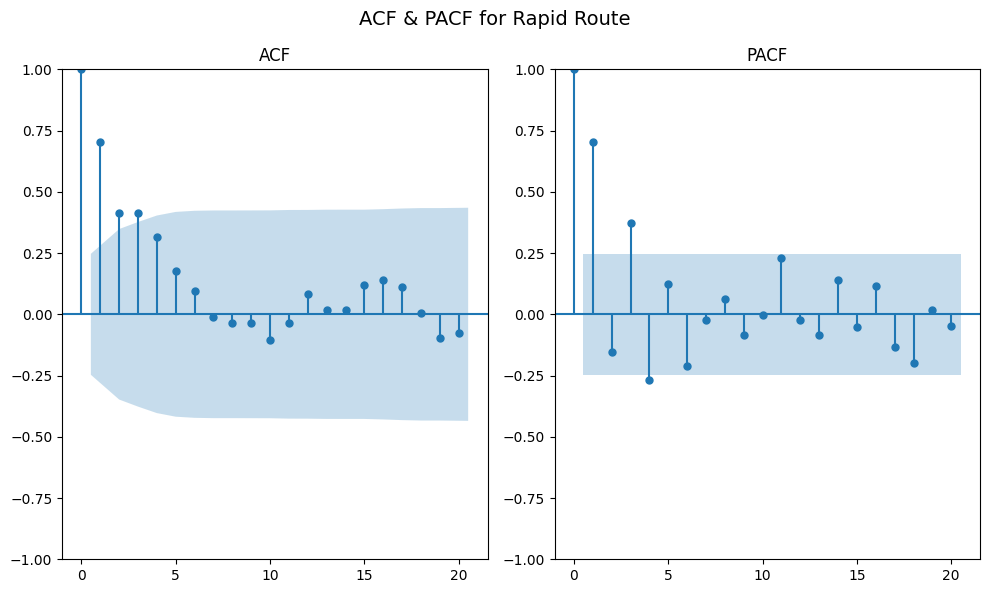

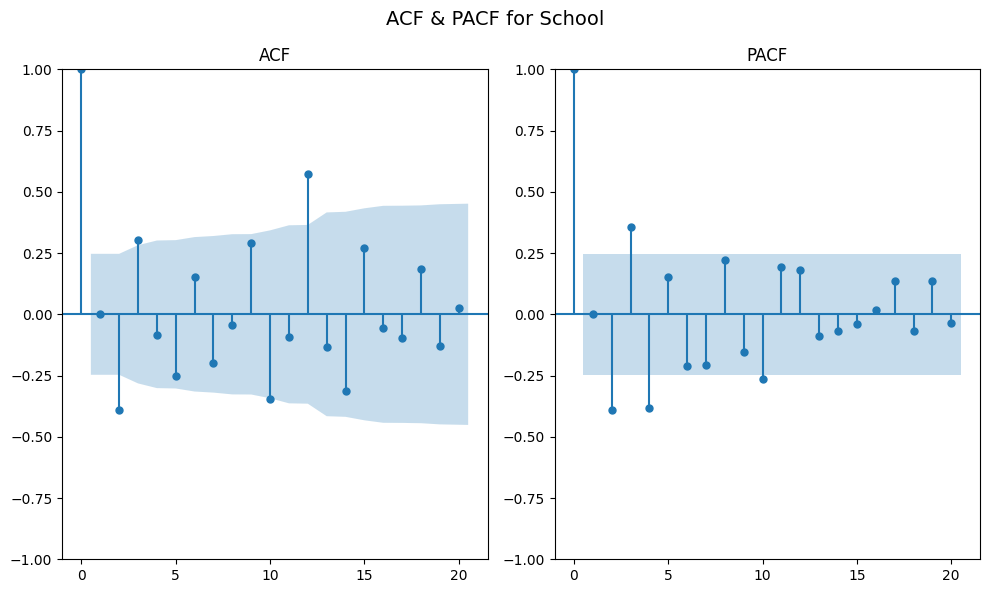

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

services = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']

for service in services:
    if service in monthly_df.columns:
        plt.figure(figsize=(10, 6))
        plt.suptitle(f"ACF & PACF for {service}", fontsize=14)
        
        # ACF
        plt.subplot(1, 2, 1)
        plot_acf(monthly_df[service].dropna(), ax=plt.gca(), lags=20)
        plt.title("ACF")
        
        # PACF
        plt.subplot(1, 2, 2)
        plot_pacf(monthly_df[service].dropna(), ax=plt.gca(), lags=20, method='ywm')
        plt.title("PACF")
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"{service} not found in dataframe")



🔹 Training ARIMA model for: Local Route


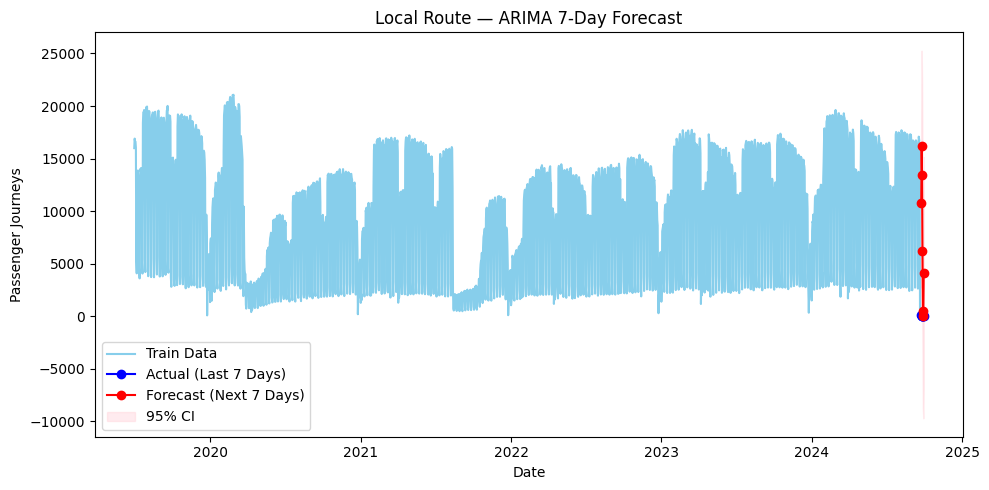


🔹 Training ARIMA model for: Light Rail


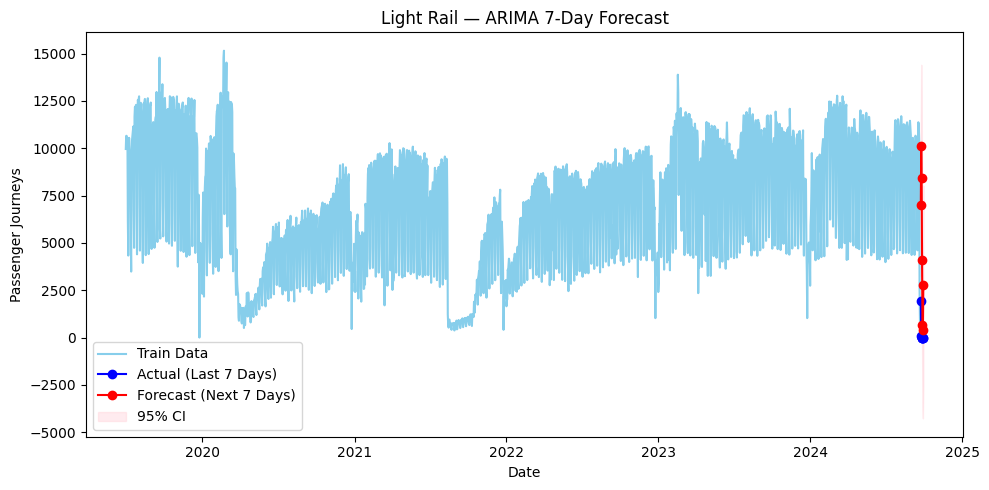


🔹 Training ARIMA model for: Peak Service


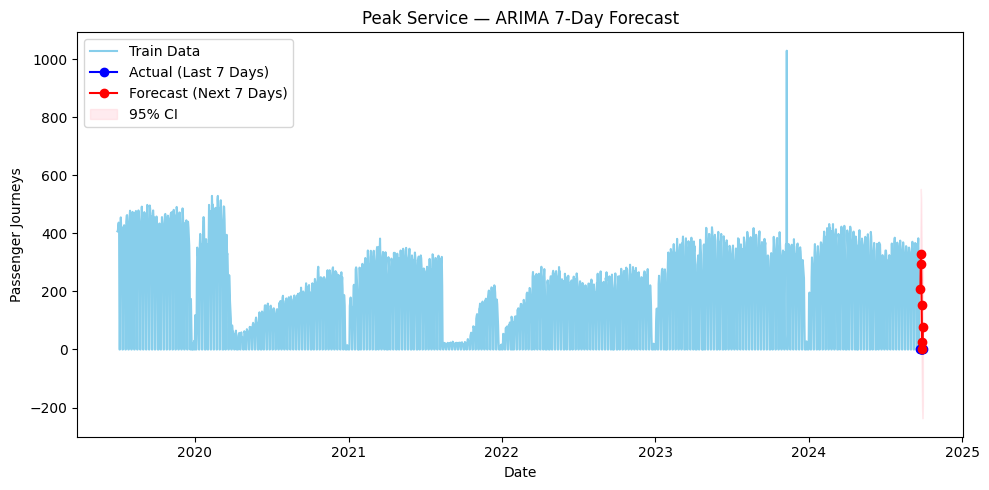


🔹 Training ARIMA model for: Rapid Route


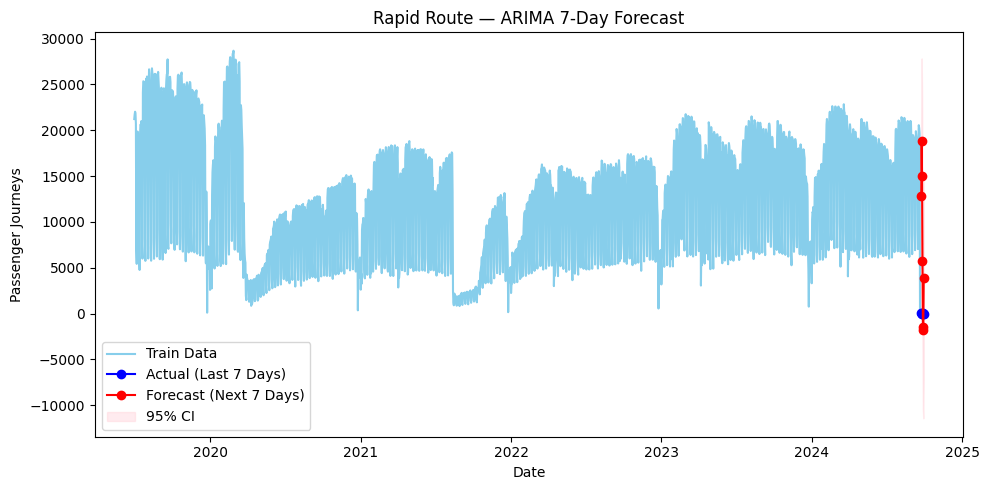


🔹 Training ARIMA model for: School


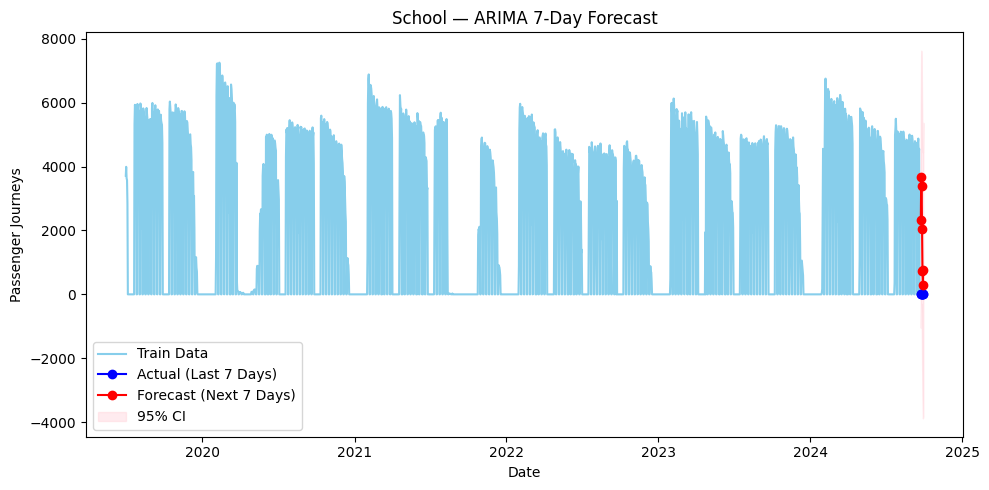


🔹 Training ARIMA model for: Other


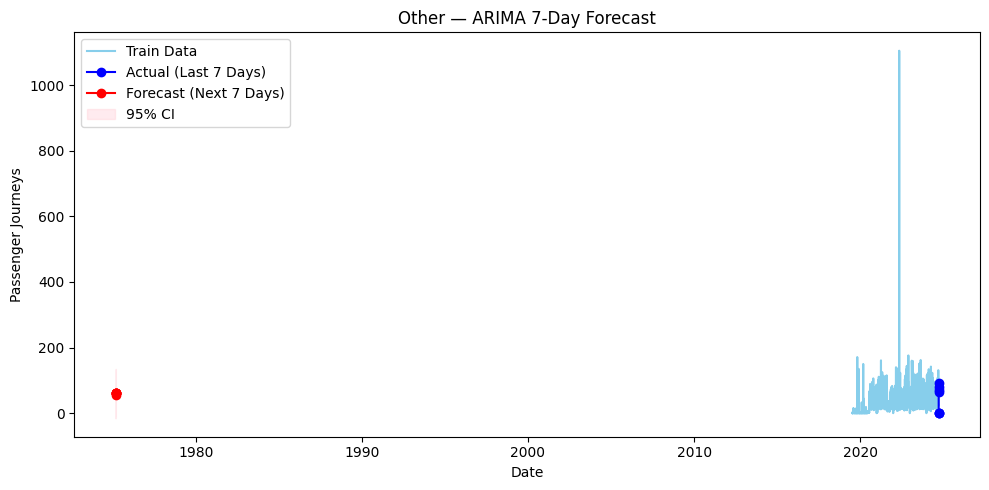

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

route_columns = [col for col in df.columns if col.lower() != 'date']


for route in route_columns:
    print(f"\n🔹 Training ARIMA model for: {route}")
    series = df[['Date', route]].dropna()
    series.set_index('Date', inplace=True)
    
    
    if len(series) < 14:
        print(f"Skipping {route} (not enough data)")
        continue
        
    train = series[:-7]
    test = series[-7:]
    
    try:

        model = ARIMA(train, order=(2, 1, 2))
        model_fit = model.fit()
        
      
        forecast = model_fit.get_forecast(steps=7)
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int()
        
       
        plt.figure(figsize=(10,5))
        plt.plot(train.index, train[route], label='Train Data', color='skyblue')
        plt.plot(test.index, test[route], label='Actual (Last 7 Days)', color='blue', marker='o')
        plt.plot(forecast_mean.index, forecast_mean, label='Forecast (Next 7 Days)', color='red', marker='o')
        plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], 
                         color='pink', alpha=0.3, label='95% CI')
        
        plt.title(f"{route} — ARIMA 7-Day Forecast")
        plt.xlabel("Date")
        plt.ylabel("Passenger Journeys")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"⚠️ Error while training {route}: {e}")
